In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr
import os
import random

/content/drive/MyDrive/osldvfs


In [2]:
DATA_PATH = "./combined_perf_pow.csv"

In [ ]:
p1 = np.array([0.1, 0.2, 0.5])
p2 = np.array([0.5, 0.4, 0.7])
p3 = np.array([0.6, 0.3, 1.0])

print(np.sqrt((((p1[2] - p2[2]) ** 2) + ((p1[1] - p2[1]) ** 2) + ((p1[0] - p2[0]) ** 2))))
print(np.sqrt((((p1[2] - p3[2]) ** 2) + ((p1[1] - p3[1]) ** 2) + ((p1[0] - p3[0]) ** 2))))

p1[2] *= 4
p2[2] *= 4
p3[2] *= 4

print(np.sqrt(((p1[2] - p2[2]) ** 2) + ((p1[1] - p2[1]) ** 2) + ((p1[0] - p2[0]) ** 2)))
print(np.sqrt(((p1[2] - p3[2]) ** 2) + ((p1[1] - p3[1]) ** 2) + ((p1[0] - p3[0]) ** 2)))

# Ratio of changes in distance is not the same between different pairs of points

0.48989794855663565
0.714142842854285
0.9165151389911679
2.0639767440550294


In [ ]:
first = np.arange(10, 21, 2)
second = np.arange(0, 11, 2)
print(first)
print(second)

[10 12 14 16 18 20]
[ 0  2  4  6  8 10]


In [ ]:
print(first / first.max())
print(second / second.max())

[0.5 0.6 0.7 0.8 0.9 1. ]
[0.  0.2 0.4 0.6 0.8 1. ]


In [ ]:
print((first - first.min()) / (first.max() - first.min()))
print((second - second.min()) / (second.max() - second.min()))

[0.  0.2 0.4 0.6 0.8 1. ]
[0.  0.2 0.4 0.6 0.8 1. ]


In [18]:
# Your function get_cmap() results in similar-looking colors!
color_dict = {0 : "red",
              1 : "orange",
              2 : "yellow",
              3 : "green",
              4 : "blue",
              5 : "purple",
              6 : "black"}

In [17]:
# For dealing with overlapping points
# https://stackoverflow.com/a/21276920

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(ax, x, y, s=20, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, **kwargs):
    return ax.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, **kwargs)

In [5]:
CPU_FREQ_COL = "CPU Frequencies"
GPU_FREQ_COL = "GPU Frequencies"
MEM_FREQ_COL = "Mem Frequencies"
INIT_TIME_COL = "Initialization Time"
ALLOC_TIME_COL = "Allocation Time"
CP_HTD_COL = "Copy To Device Time"
KERNEL_TIME_COL = "Kernel Time"
CP_DTH_COL = "Copy Back and Merge Time"
DALLOC_TIME_COL = "Deallocation Time"
REAL_TIME_COL = "Real Time"
USR_TIME_COL = "User Time"
SYS_TIME_COL = "System Time"
TOT_DATA_TRANSFER_LATENCY_COL = "Total Data Transfer Latency"
TOT_LATENCY_COL = "Total Latency"
TRANS_PERCENT_COL = "Transfer Percentage"
KERNEL_STD_COL = "Kernel STD"
TRANSFER_STD_COL = "Transfer STD"
KERNEL_SCORE_COL = "Kernel Score"
TRANSFER_SCORE_COL = "Transfer Score"
TOT_SCORE = "Total Score"
IDLE_POWER = "IdlePower"
ACTIVE_POWER = "ActivePower"

In [8]:
def get_data():
    '''Returns a pandas dataframe containing the data in DATA_PATH'''
    df = pd.read_csv(DATA_PATH)
    df[TOT_DATA_TRANSFER_LATENCY_COL] = df[CP_HTD_COL] + df[CP_DTH_COL]
    df[TOT_LATENCY_COL] = df[TOT_DATA_TRANSFER_LATENCY_COL] + df[KERNEL_TIME_COL]
    df[TOT_SCORE] = (df[TOT_LATENCY_COL].max()/df[TOT_LATENCY_COL])
    return df

In [9]:
df = get_data()
df.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time,Starttime,Endtime,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,46363.0,19438.0,10767.0,405.0,46822.0,4.362,2.189,6313.179,16198.261,1.033157
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,40930.0,19075.0,10068.0,47290.0,88265.0,4.483,2.190,6265.787,14110.555,1.186016
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,36717.0,18457.0,9720.0,88666.0,125422.0,4.477,2.205,6134.266,12204.363,1.371259
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,33387.0,17890.0,9513.0,125765.0,159189.0,4.659,2.227,6018.016,10714.089,1.561994
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,31822.0,17584.0,9332.0,159512.0,191367.0,5.081,2.264,5954.440,10023.311,1.669642


In [12]:
def normalize_and_weight_performance(df, performance_weight = 1):
    '''Normalizes "GPUPower", "MemPower", "CPUPower", "GPU", "CPU", "Mem" in the
       data frame "df" to between 0 and 1, and multiplies the performance
       benchmark values ("GPU", "CPU", and "Mem") by "performance_weight".
       If performance_weight > 1, it means we value performance more than power
       (and the bigger it is, the more we value performance)
       If performance_weight < 1, it means we value power more than performance
       (and the smaller it is, the more we value power)
       performance_weight is between 0 and infinity
       performance_weight is 1 by default, same as NU = 2, power and performance are equally important
       '''
    output = df.copy()

    # You were dividing by max. Doesn't normalization use the formula (x - x_min) / (x_max - x_min)?
    # Previously, if one variable has range [5, 10] and another has range [0, 10], then the first is mapped 
    # to [0.5, 1] and the second is mapped to [0, 1]. The second has much more variation and is more important.
    for feat_name in [CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL,ACTIVE_POWER,TOT_SCORE]:
        output[feat_name + "_Transformed"] = output[feat_name].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    for feat_name in [TOT_SCORE]:
        output[feat_name + "_Transformed"] = output[feat_name + "_Transformed"].transform(lambda x: x * performance_weight)

    return output

In [13]:
df_weight_1 = normalize_and_weight_performance(df, 1)
df_weight_1.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,...,4.362,2.189,6313.179,16198.261,1.033157,0.0,1.0,0.000000,0.297324,0.006650
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,...,4.483,2.190,6265.787,14110.555,1.186016,0.0,1.0,0.062121,0.321308,0.037307
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,...,4.477,2.205,6134.266,12204.363,1.371259,0.0,1.0,0.166667,0.320119,0.074460
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,...,4.659,2.227,6018.016,10714.089,1.561994,0.0,1.0,0.375758,0.356194,0.112713
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,...,5.081,2.264,5954.440,10023.311,1.669642,0.0,1.0,0.572727,0.439841,0.134303


In [14]:
df_weight_1.describe()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed
count,1064.000000,1.064000e+03,1.064000e+03,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,...,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,531.500000,1.100000e+06,4.051429e+08,4.735000e+08,2400.545090,13.391821,1355.155238,4395.308882,814.204289,28.999721,...,4.718928,2.940004,2169.359526,6564.668408,3.033404,0.500000,0.539345,0.467424,0.368073,0.407819
std,307.294647,5.479801e+05,1.400908e+08,2.315132e+08,1659.453104,7.760130,783.266763,2046.182332,485.018225,17.083647,...,0.950786,0.585979,1266.232018,2847.424253,1.211825,0.304433,0.331184,0.350778,0.188461,0.243043
min,0.000000,2.000000e+05,1.770000e+08,1.650000e+08,911.597000,5.613000,576.704000,1866.898000,314.561000,11.570000,...,2.862000,2.071000,891.265000,2795.727000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,265.750000,6.000000e+05,2.660000e+08,2.577500e+08,1330.899250,7.979000,848.776250,2649.876250,458.303750,17.001000,...,3.985500,2.465750,1311.779250,4222.268500,2.009212,0.222222,0.210402,0.140530,0.222696,0.202407
50%,531.500000,1.100000e+06,4.200000e+08,4.780000e+08,1789.700500,11.557000,1134.841500,3782.146000,668.646000,24.125500,...,4.645000,2.827000,1806.117500,5929.292000,2.822486,0.500000,0.574468,0.474242,0.353419,0.365518
75%,797.250000,1.600000e+06,5.430000e+08,6.567500e+08,2745.767250,16.100000,1483.414750,6073.969750,975.887250,33.380000,...,5.389250,3.305250,2470.699750,8329.313000,3.963590,0.777778,0.865248,0.745076,0.500942,0.594377
max,1063.000000,2.000000e+06,6.000000e+08,8.250000e+08,8294.003000,126.079000,4392.729000,9976.650000,2544.532000,95.691000,...,7.907000,4.852000,6937.261000,16735.341000,5.986043,1.000000,1.000000,1.000000,1.000000,1.000000


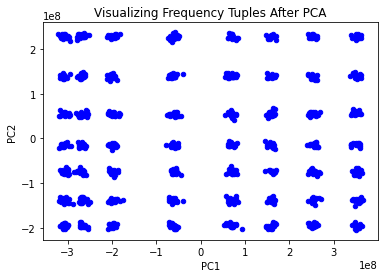

In [19]:
# Plot the distribution of the frequency tubles ("MemFreq", "CPUBig", "CPUSmall", "GPUFreq")

def plot_pca(df):
    ''' This function takes the data (in a format similar to that in PowerDVFS.csv)
        does PCA with 2 components on the 4 frequency values, and plots the frequency
        tuples in a 2-dimensional space.
        If the argument "df" has a column for clusters (there can be at most 7 clusters)
        then points representing each frequency tuple will be colored according to which
        cluster they were assigned to (based on their component power consumptions
        and performance benchmark scores)
        The purpose of this is to visualize our clustering.
    '''

    scaled_freq_df = StandardScaler().fit_transform(df[[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]])
    pca = PCA(n_components = 2)
    pca.fit(df[[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]])
    pca_df = pd.DataFrame(data = pca.transform(df[[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]]), columns = ["PC1", "PC2"])

    fig, ax = plt.subplots()

    # jitter() adds some jitter so we can see different points that are close
    # together distinctly.
    if "cluster" in df.columns:
        pca_df["cluster"] = df["cluster"]
        jitter(ax, pca_df["PC1"], pca_df["PC2"], c = pca_df["cluster"].map(color_dict)) 
    else:
        jitter(ax, pca_df["PC1"], pca_df["PC2"]) 

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Visualizing Frequency Tuples After PCA")

    plt.show()

plot_pca(df)

In [20]:
def kmeans_power_performance(df, num_clusters):
    # This takes a dataframe of normalized and weighted data from "PowerDVFS.csv"
    # and usees k-means with k = "num_clusters" to cluster the observations
    # based on their transformed power and performance scores for each component.
    # It returns the fitted model and a copy of the dataframe in which each point
    # is labeled by its cluster id
    output = df.copy()
    kmeanModel = KMeans(n_clusters = num_clusters).fit(output[["ActivePower_Transformed","Total Score_Transformed"
                                                               ]])
    output["cluster"] = kmeanModel.labels_.tolist()
    return kmeanModel, output

In [21]:
def print_clusters(df, clustering_model, num_clusters):
    # This takes a dataframe of data from "PowerDVFS.csv" with with each observation
    # having a cluster id in the range [0, num_clusters), and a clustering model,
    # and prints the center of each cluster (a 6-tuple of power and performance scores)
    # as well as the frequency tuple of all observations in that cluster

    for i in range(num_clusters):
        print("cluster", i)
        # if hasattr(clustering_model, 'cluster_centers_'):
            # print("cluster center:")
            # print(clustering_model.cluster_centers_[i])
        # else:
        print("average point in cluster")
        print(df.loc[df.cluster == i][["ActivePower_Transformed",
                                       "Total Score_Transformed"
                                    ]].mean())
        print(df.loc[df.cluster == i][[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]])

In [22]:
num_clusters = 4
kmeans_model_weight_1, df_weight_1 = kmeans_power_performance(df_weight_1, num_clusters)
df_weight_1.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed,cluster
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,...,2.189,6313.179,16198.261,1.033157,0.0,1.0,0.000000,0.297324,0.006650,2
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,...,2.190,6265.787,14110.555,1.186016,0.0,1.0,0.062121,0.321308,0.037307,2
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,...,2.205,6134.266,12204.363,1.371259,0.0,1.0,0.166667,0.320119,0.074460,2
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,...,2.227,6018.016,10714.089,1.561994,0.0,1.0,0.375758,0.356194,0.112713,0
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,...,2.264,5954.440,10023.311,1.669642,0.0,1.0,0.572727,0.439841,0.134303,0


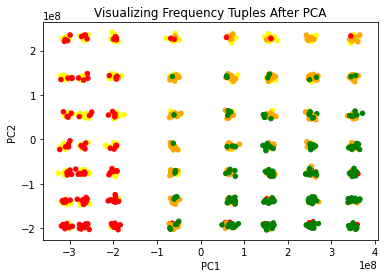

In [23]:
# Plot how the frequency tubles ("MemFreq", "CPUBig", "CPUSmall", "GPUFreq") are clustered
plot_pca(df_weight_1)

In [24]:
print_clusters(df_weight_1, kmeans_model_weight_1, num_clusters)

cluster 0
average point in cluster
ActivePower_Transformed    0.480726
Total Score_Transformed    0.244156
dtype: float64
      CPU Frequencies  GPU Frequencies  Mem Frequencies
3            200000.0      600000000.0      413000000.0
4            200000.0      600000000.0      543000000.0
5            200000.0      600000000.0      633000000.0
6            200000.0      600000000.0      728000000.0
7            200000.0      600000000.0      825000000.0
...               ...              ...              ...
1058        2000000.0      177000000.0      275000000.0
1059        2000000.0      177000000.0      413000000.0
1060        2000000.0      177000000.0      543000000.0
1061        2000000.0      177000000.0      633000000.0
1063        2000000.0      177000000.0      825000000.0

[194 rows x 3 columns]
cluster 1
average point in cluster
ActivePower_Transformed    0.358903
Total Score_Transformed    0.532051
dtype: float64
      CPU Frequencies  GPU Frequencies  Mem Frequencies
134 

In [25]:
for i in range(5):
    kmeans_model_weight_1, df_weight_1 = kmeans_power_performance(df_weight_1, num_clusters)
    clusters_set = set()
    for c in range(num_clusters):
        clusters_set.add(tuple(np.where(df_weight_1.cluster == c)[0])) # index 0 to get indices belonging to cluster c
    
    print("iteration", i)
    print(clusters_set)
    if i > 0:
        print(clusters_set == last_clusters_set)
    
    last_clusters_set = clusters_set

# For weight = 1 and with k-means using 4 clusters, the results are always the same

iteration 0
{(230, 231, 286, 287, 295, 341, 342, 343, 350, 351, 396, 397, 398, 399, 406, 407, 415, 452, 453, 454, 455, 461, 462, 463, 470, 471, 508, 509, 510, 511, 517, 518, 519, 526, 527, 535, 564, 565, 566, 567, 573, 574, 575, 581, 582, 583, 590, 591, 620, 621, 622, 623, 628, 629, 630, 631, 637, 638, 639, 645, 646, 647, 676, 677, 678, 679, 684, 685, 686, 687, 693, 694, 695, 701, 702, 703, 710, 731, 732, 733, 734, 735, 740, 741, 742, 743, 748, 749, 750, 751, 757, 758, 759, 767, 787, 788, 789, 790, 791, 796, 797, 798, 799, 804, 805, 806, 807, 813, 814, 815, 822, 823, 843, 844, 845, 846, 847, 852, 853, 854, 855, 860, 861, 862, 863, 869, 870, 871, 877, 878, 879, 899, 900, 901, 902, 903, 907, 908, 909, 910, 911, 916, 917, 918, 919, 924, 925, 926, 927, 932, 933, 934, 935, 955, 956, 957, 958, 959, 963, 964, 965, 966, 967, 971, 972, 973, 974, 975, 980, 981, 982, 983, 988, 989, 990, 991, 996, 997, 998, 999, 1011, 1012, 1013, 1014, 1015, 1019, 1020, 1021, 1022, 1023, 1027, 1028, 1029, 1030, 10

iteration 4
{(3, 4, 5, 6, 7, 15, 58, 59, 60, 61, 62, 63, 69, 70, 71, 77, 78, 79, 114, 115, 116, 117, 118, 119, 123, 124, 125, 126, 127, 133, 169, 170, 171, 172, 173, 174, 175, 179, 224, 225, 226, 227, 280, 281, 282, 336, 337, 338, 392, 393, 394, 402, 448, 449, 450, 458, 504, 505, 506, 513, 514, 560, 561, 562, 569, 570, 616, 617, 618, 624, 625, 626, 634, 672, 673, 674, 680, 681, 682, 690, 728, 729, 730, 736, 737, 738, 745, 746, 784, 785, 786, 792, 793, 794, 800, 801, 802, 808, 809, 810, 834, 840, 841, 842, 848, 849, 850, 856, 857, 858, 864, 865, 866, 872, 873, 874, 880, 881, 882, 888, 890, 896, 897, 898, 904, 905, 906, 912, 913, 914, 920, 921, 922, 928, 929, 930, 936, 937, 938, 944, 945, 946, 952, 953, 954, 960, 961, 962, 968, 969, 970, 976, 977, 978, 984, 985, 986, 992, 993, 994, 1000, 1001, 1002, 1003, 1008, 1009, 1010, 1016, 1017, 1018, 1024, 1025, 1026, 1032, 1033, 1034, 1040, 1041, 1042, 1048, 1049, 1050, 1056, 1057, 1058, 1059, 1060, 1061, 1063), (230, 231, 286, 287, 295, 341, 342

In [26]:
len(df[[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]].drop_duplicates()) # All frequency combinations are unique

1064

In [28]:
scaled_freq_df = StandardScaler().fit_transform(df[[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]])
pca = PCA(n_components = 2)
pca.fit(df[[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]])
pca_df = pd.DataFrame(data = pca.transform(df[[CPU_FREQ_COL,GPU_FREQ_COL,MEM_FREQ_COL]]), columns = ["PC1", "PC2"])

len(pca_df.drop_duplicates()) # All PCA combinations are unique, but many apparently are very similar

56

In [29]:
kmeans_model_weight_1.inertia_

20.191670293720325

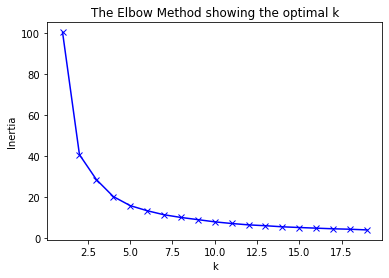

In [30]:
K = range(1, 20)
inertias = []

for k in K:
    kmeans_model_weight_1, df_weight_1 = kmeans_power_performance(df_weight_1, k)
    inertias.append(kmeans_model_weight_1.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 4-5 seems best

In [31]:
num_clusters = 5
kmeans_model_weight_1, df_weight_1 = kmeans_power_performance(df_weight_1, num_clusters)
df_weight_1.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed,cluster
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,...,2.189,6313.179,16198.261,1.033157,0.0,1.0,0.000000,0.297324,0.006650,1
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,...,2.190,6265.787,14110.555,1.186016,0.0,1.0,0.062121,0.321308,0.037307,1
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,...,2.205,6134.266,12204.363,1.371259,0.0,1.0,0.166667,0.320119,0.074460,1
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,...,2.227,6018.016,10714.089,1.561994,0.0,1.0,0.375758,0.356194,0.112713,1
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,...,2.264,5954.440,10023.311,1.669642,0.0,1.0,0.572727,0.439841,0.134303,3


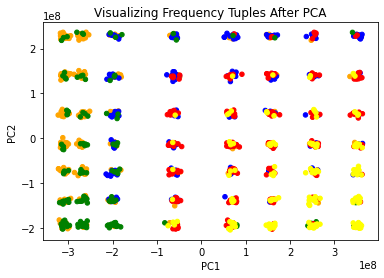

In [32]:
# Plot how the frequency tubles ("MemFreq", "CPUBig", "CPUSmall", "GPUFreq") are clustered
plot_pca(df_weight_1)

In [33]:
print_clusters(df_weight_1, kmeans_model_weight_1, num_clusters)

cluster 0
average point in cluster
ActivePower_Transformed    0.416343
Total Score_Transformed    0.588781
dtype: float64
      CPU Frequencies  GPU Frequencies  Mem Frequencies
174          500000.0      600000000.0      728000000.0
175          500000.0      600000000.0      825000000.0
181          500000.0      543000000.0      633000000.0
182          500000.0      543000000.0      728000000.0
183          500000.0      543000000.0      825000000.0
...               ...              ...              ...
1005        1900000.0      177000000.0      633000000.0
1006        1900000.0      177000000.0      728000000.0
1007        1900000.0      177000000.0      825000000.0
1051        2000000.0      266000000.0      413000000.0
1062        2000000.0      177000000.0      728000000.0

[241 rows x 3 columns]
cluster 1
average point in cluster
ActivePower_Transformed    0.177395
Total Score_Transformed    0.142039
dtype: float64
     CPU Frequencies  GPU Frequencies  Mem Frequencies
0    

In [34]:
for i in range(5):
    kmeans_model_weight_1, df_weight_1 = kmeans_power_performance(df_weight_1, num_clusters)
    clusters_set = set()
    for c in range(num_clusters):
        clusters_set.add(tuple(np.where(df_weight_1.cluster == c)[0])) # index 0 to get indices belonging to cluster c
    
    print("iteration", i)
    print(clusters_set)
    if i > 0:
        print(clusters_set == last_clusters_set)
    
    last_clusters_set = clusters_set

# For weight = 1 and with k-means using 5 clusters, the results vary slightly between iterations
# 2 different configurations, only vary based on if row 15 goes with (9, 10, 16, 18, 19) or with (2, 3, 4, 6, 7, 12, 13)

iteration 0
{(68, 69, 70, 76, 77, 78, 79, 85, 86, 87, 95, 123, 131, 132, 134, 135, 139, 140, 141, 142, 143, 147, 148, 149, 150, 151, 156, 157, 158, 159, 179, 180, 187, 188, 189, 195, 196, 197, 198, 203, 204, 205, 206, 207, 211, 212, 213, 214, 215, 234, 235, 242, 243, 250, 251, 252, 259, 260, 261, 262, 267, 268, 269, 270, 271, 277, 278, 279, 290, 291, 298, 299, 306, 307, 314, 315, 316, 317, 323, 324, 325, 326, 327, 332, 333, 334, 335, 346, 347, 354, 355, 362, 363, 370, 371, 378, 379, 380, 381, 382, 383, 387, 388, 389, 390, 391, 402, 410, 411, 418, 419, 426, 427, 434, 435, 436, 437, 438, 439, 443, 444, 445, 446, 447, 458, 466, 474, 475, 482, 483, 490, 491, 492, 493, 499, 500, 501, 502, 503, 514, 522, 530, 538, 539, 546, 547, 548, 554, 555, 556, 557, 558, 559, 570, 578, 586, 594, 595, 602, 603, 604, 610, 611, 612, 613, 614, 615, 626, 634, 642, 650, 658, 659, 666, 667, 668, 669, 670, 671, 690, 698, 706, 714, 715, 722, 723, 724, 725, 726, 727, 754, 762, 770, 771, 778, 779, 780, 781, 782, 78

iteration 4
{(0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 64, 65, 66, 67, 72, 73, 74, 75, 80, 81, 82, 83, 84, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 120, 121, 122, 128, 129, 130, 136, 137, 138, 144, 145, 146, 152, 153, 154, 155, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 176, 177, 178, 184, 185, 186, 192, 193, 194, 200, 201, 202, 208, 209, 210, 216, 217, 218, 219, 220, 221, 222, 223, 224, 232, 233, 240, 241, 248, 249, 256, 257, 258, 264, 265, 266, 272, 273, 274, 275, 280, 288, 289, 296, 297, 304, 305, 312, 313, 320, 321, 322, 328, 329, 330, 336, 344, 345, 352, 353, 360, 361, 368, 369, 376, 377, 384, 385, 392, 400, 401, 408, 409, 416, 417, 424, 425, 432, 433, 440, 441, 442, 456, 457, 464, 465, 472, 473, 480, 481, 488, 489, 496, 497, 498, 512, 520, 521

In [35]:
pca_df.loc[15]

PC1    3.515000e+08
PC2   -1.378571e+08
Name: 15, dtype: float64

In [36]:
# Performance more important (how much?)
df_weight_2 = normalize_and_weight_performance(df, 2)
df_weight_2.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,...,4.362,2.189,6313.179,16198.261,1.033157,0.0,1.0,0.000000,0.297324,0.013300
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,...,4.483,2.190,6265.787,14110.555,1.186016,0.0,1.0,0.062121,0.321308,0.074615
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,...,4.477,2.205,6134.266,12204.363,1.371259,0.0,1.0,0.166667,0.320119,0.148919
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,...,4.659,2.227,6018.016,10714.089,1.561994,0.0,1.0,0.375758,0.356194,0.225427
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,...,5.081,2.264,5954.440,10023.311,1.669642,0.0,1.0,0.572727,0.439841,0.268607


In [37]:
df_weight_2.describe()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed
count,1064.000000,1.064000e+03,1.064000e+03,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,...,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,531.500000,1.100000e+06,4.051429e+08,4.735000e+08,2400.545090,13.391821,1355.155238,4395.308882,814.204289,28.999721,...,4.718928,2.940004,2169.359526,6564.668408,3.033404,0.500000,0.539345,0.467424,0.368073,0.815638
std,307.294647,5.479801e+05,1.400908e+08,2.315132e+08,1659.453104,7.760130,783.266763,2046.182332,485.018225,17.083647,...,0.950786,0.585979,1266.232018,2847.424253,1.211825,0.304433,0.331184,0.350778,0.188461,0.486087
min,0.000000,2.000000e+05,1.770000e+08,1.650000e+08,911.597000,5.613000,576.704000,1866.898000,314.561000,11.570000,...,2.862000,2.071000,891.265000,2795.727000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,265.750000,6.000000e+05,2.660000e+08,2.577500e+08,1330.899250,7.979000,848.776250,2649.876250,458.303750,17.001000,...,3.985500,2.465750,1311.779250,4222.268500,2.009212,0.222222,0.210402,0.140530,0.222696,0.404815
50%,531.500000,1.100000e+06,4.200000e+08,4.780000e+08,1789.700500,11.557000,1134.841500,3782.146000,668.646000,24.125500,...,4.645000,2.827000,1806.117500,5929.292000,2.822486,0.500000,0.574468,0.474242,0.353419,0.731035
75%,797.250000,1.600000e+06,5.430000e+08,6.567500e+08,2745.767250,16.100000,1483.414750,6073.969750,975.887250,33.380000,...,5.389250,3.305250,2470.699750,8329.313000,3.963590,0.777778,0.865248,0.745076,0.500942,1.188755
max,1063.000000,2.000000e+06,6.000000e+08,8.250000e+08,8294.003000,126.079000,4392.729000,9976.650000,2544.532000,95.691000,...,7.907000,4.852000,6937.261000,16735.341000,5.986043,1.000000,1.000000,1.000000,1.000000,2.000000


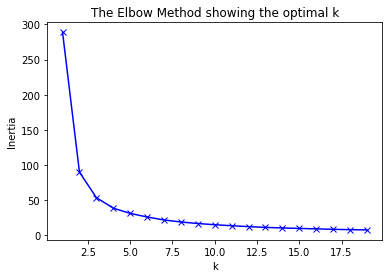

In [38]:
K = range(1, 20)
inertias = []

for k in K:
    kmeans_model_weight_2, df_weight_2 = kmeans_power_performance(df_weight_2, k)
    inertias.append(kmeans_model_weight_2.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 4 seems best

In [39]:
num_clusters = 4
kmeans_model_weight_2, df_weight_2 = kmeans_power_performance(df_weight_2, num_clusters)
df_weight_2.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed,cluster
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,...,2.189,6313.179,16198.261,1.033157,0.0,1.0,0.000000,0.297324,0.013300,3
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,...,2.190,6265.787,14110.555,1.186016,0.0,1.0,0.062121,0.321308,0.074615,3
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,...,2.205,6134.266,12204.363,1.371259,0.0,1.0,0.166667,0.320119,0.148919,3
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,...,2.227,6018.016,10714.089,1.561994,0.0,1.0,0.375758,0.356194,0.225427,3
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,...,2.264,5954.440,10023.311,1.669642,0.0,1.0,0.572727,0.439841,0.268607,3


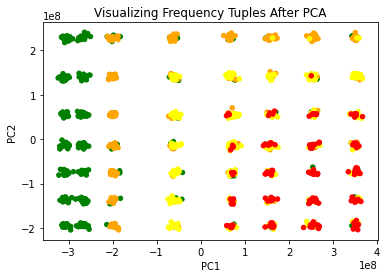

In [40]:
# Plot how the frequency tubles ("MemFreq", "CPUBig", "CPUSmall", "GPUFreq") are clustered
plot_pca(df_weight_2)

In [41]:
print_clusters(df_weight_2, kmeans_model_weight_2, num_clusters)

cluster 0
average point in cluster
ActivePower_Transformed    0.607733
Total Score_Transformed    1.594400
dtype: float64
      CPU Frequencies  GPU Frequencies  Mem Frequencies
343          800000.0      600000000.0      825000000.0
398          900000.0      600000000.0      728000000.0
399          900000.0      600000000.0      825000000.0
406          900000.0      543000000.0      728000000.0
407          900000.0      543000000.0      825000000.0
...               ...              ...              ...
1044        2000000.0      350000000.0      543000000.0
1045        2000000.0      350000000.0      633000000.0
1046        2000000.0      350000000.0      728000000.0
1047        2000000.0      350000000.0      825000000.0
1054        2000000.0      266000000.0      728000000.0

[172 rows x 3 columns]
cluster 1
average point in cluster
ActivePower_Transformed    0.311124
Total Score_Transformed    0.723825
dtype: float64
      CPU Frequencies  GPU Frequencies  Mem Frequencies
61  

In [ ]:
for i in range(5):
    kmeans_model_weight_2, df_weight_2 = kmeans_power_performance(df_weight_2, num_clusters)
    clusters_set = set()
    for c in range(num_clusters):
        clusters_set.add(tuple(np.where(df_weight_2.cluster == c)[0])) # index 0 to get indices belonging to cluster c
    
    print("iteration", i)
    print(clusters_set)
    if i > 0:
        print(clusters_set == last_clusters_set)
    
    last_clusters_set = clusters_set

# For weight = 2 and with k-means using 4 clusters, the results vary significantly

iteration 0
{(21, 22, 24, 25, 27, 28), (0, 1, 5, 8, 11, 14, 17, 20, 23, 26), (6, 7, 9, 10, 15, 16, 18, 19), (2, 3, 4, 12, 13)}
iteration 1
{(21, 22, 24, 25, 27, 28), (0, 1, 5, 8, 11, 14, 17, 20, 23, 26), (6, 7, 9, 10, 15, 16, 18, 19), (2, 3, 4, 12, 13)}
True
iteration 2
{(21, 22, 24, 25, 27, 28), (0, 1, 5, 8, 11, 14, 17, 20, 23, 26), (6, 7, 9, 10, 15, 16, 18, 19), (2, 3, 4, 12, 13)}
True
iteration 3
{(21, 22, 24, 25, 27, 28), (0, 1, 5, 8, 11, 14, 17, 20, 23, 26), (6, 7, 9, 10, 15, 16, 18, 19), (2, 3, 4, 12, 13)}
True
iteration 4
{(21, 22, 24, 25, 27, 28), (0, 1, 5, 8, 11, 14, 17, 20, 23, 26), (9, 10, 18, 19), (2, 3, 4, 6, 7, 12, 13, 15, 16)}
False


In [42]:
# Power more important (how much?)
df_weight_half = normalize_and_weight_performance(df, 0.5)
df_weight_half.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,...,4.362,2.189,6313.179,16198.261,1.033157,0.0,1.0,0.000000,0.297324,0.003325
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,...,4.483,2.190,6265.787,14110.555,1.186016,0.0,1.0,0.062121,0.321308,0.018654
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,...,4.477,2.205,6134.266,12204.363,1.371259,0.0,1.0,0.166667,0.320119,0.037230
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,...,4.659,2.227,6018.016,10714.089,1.561994,0.0,1.0,0.375758,0.356194,0.056357
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,...,5.081,2.264,5954.440,10023.311,1.669642,0.0,1.0,0.572727,0.439841,0.067152


In [43]:
df_weight_half.describe()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,ActivePower,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed
count,1064.000000,1.064000e+03,1.064000e+03,1.064000e+03,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,...,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000,1064.000000
mean,531.500000,1.100000e+06,4.051429e+08,4.735000e+08,2400.545090,13.391821,1355.155238,4395.308882,814.204289,28.999721,...,4.718928,2.940004,2169.359526,6564.668408,3.033404,0.500000,0.539345,0.467424,0.368073,0.203910
std,307.294647,5.479801e+05,1.400908e+08,2.315132e+08,1659.453104,7.760130,783.266763,2046.182332,485.018225,17.083647,...,0.950786,0.585979,1266.232018,2847.424253,1.211825,0.304433,0.331184,0.350778,0.188461,0.121522
min,0.000000,2.000000e+05,1.770000e+08,1.650000e+08,911.597000,5.613000,576.704000,1866.898000,314.561000,11.570000,...,2.862000,2.071000,891.265000,2795.727000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,265.750000,6.000000e+05,2.660000e+08,2.577500e+08,1330.899250,7.979000,848.776250,2649.876250,458.303750,17.001000,...,3.985500,2.465750,1311.779250,4222.268500,2.009212,0.222222,0.210402,0.140530,0.222696,0.101204
50%,531.500000,1.100000e+06,4.200000e+08,4.780000e+08,1789.700500,11.557000,1134.841500,3782.146000,668.646000,24.125500,...,4.645000,2.827000,1806.117500,5929.292000,2.822486,0.500000,0.574468,0.474242,0.353419,0.182759
75%,797.250000,1.600000e+06,5.430000e+08,6.567500e+08,2745.767250,16.100000,1483.414750,6073.969750,975.887250,33.380000,...,5.389250,3.305250,2470.699750,8329.313000,3.963590,0.777778,0.865248,0.745076,0.500942,0.297189
max,1063.000000,2.000000e+06,6.000000e+08,8.250000e+08,8294.003000,126.079000,4392.729000,9976.650000,2544.532000,95.691000,...,7.907000,4.852000,6937.261000,16735.341000,5.986043,1.000000,1.000000,1.000000,1.000000,0.500000


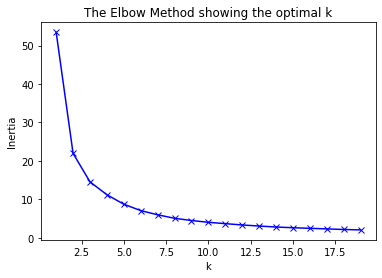

In [44]:
K = range(1, 20)
inertias = []

for k in K:
    kmeans_model_weight_half, df_weight_half = kmeans_power_performance(df_weight_half, k)
    inertias.append(kmeans_model_weight_half.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 4 seems best

In [45]:
num_clusters = 4
kmeans_model_weight_half, df_weight_half = kmeans_power_performance(df_weight_half, num_clusters)
df_weight_half.head()

,Index,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,...,IdlePower,Total Data Transfer Latency,Total Latency,Total Score,CPU Frequencies_Transformed,GPU Frequencies_Transformed,Mem Frequencies_Transformed,ActivePower_Transformed,Total Score_Transformed,cluster
0,0,200000.0,600000000.0,165000000.0,8294.003,126.079,3920.946,9885.082,2392.233,91.676,...,2.189,6313.179,16198.261,1.033157,0.0,1.0,0.000000,0.297324,0.003325,1
1,1,200000.0,600000000.0,206000000.0,8027.128,37.392,3921.070,7844.768,2344.717,87.863,...,2.190,6265.787,14110.555,1.186016,0.0,1.0,0.062121,0.321308,0.018654,3
2,2,200000.0,600000000.0,275000000.0,7865.654,36.395,3826.231,6070.097,2308.035,84.314,...,2.205,6134.266,12204.363,1.371259,0.0,1.0,0.166667,0.320119,0.037230,3
3,3,200000.0,600000000.0,413000000.0,7695.940,33.226,3746.202,4696.073,2271.814,80.307,...,2.227,6018.016,10714.089,1.561994,0.0,1.0,0.375758,0.356194,0.056357,3
4,4,200000.0,600000000.0,543000000.0,7500.646,31.497,3715.935,4068.871,2238.505,78.447,...,2.264,5954.440,10023.311,1.669642,0.0,1.0,0.572727,0.439841,0.067152,3


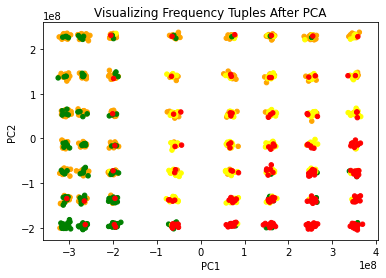

In [46]:
# Plot how the frequency tubles ("MemFreq", "CPUBig", "CPUSmall", "GPUFreq") are clustered
plot_pca(df_weight_half)

In [47]:
print_clusters(df_weight_half, kmeans_model_weight_half, num_clusters)

cluster 0
average point in cluster
ActivePower_Transformed    0.633598
Total Score_Transformed    0.358675
dtype: float64
      CPU Frequencies  GPU Frequencies  Mem Frequencies
119          400000.0      600000000.0      825000000.0
173          500000.0      600000000.0      633000000.0
174          500000.0      600000000.0      728000000.0
175          500000.0      600000000.0      825000000.0
229          600000.0      600000000.0      633000000.0
...               ...              ...              ...
1059        2000000.0      177000000.0      413000000.0
1060        2000000.0      177000000.0      543000000.0
1061        2000000.0      177000000.0      633000000.0
1062        2000000.0      177000000.0      728000000.0
1063        2000000.0      177000000.0      825000000.0

[213 rows x 3 columns]
cluster 1
average point in cluster
ActivePower_Transformed    0.178830
Total Score_Transformed    0.110659
dtype: float64
     CPU Frequencies  GPU Frequencies  Mem Frequencies
0    

In [ ]:
for i in range(5):
    kmeans_model_weight_half, df_weight_half = kmeans_power_performance(df_weight_half, num_clusters)
    clusters_set = set()
    for c in range(num_clusters):
        clusters_set.add(tuple(np.where(df_weight_half.cluster == c)[0])) # index 0 to get indices belonging to cluster c
    
    print("iteration", i)
    print(clusters_set)
    if i > 0:
        print(clusters_set == last_clusters_set)
    
    last_clusters_set = clusters_set

# For weight =0.5 and with k-means using 4 clusters, the results are always stable

iteration 0
{(21, 22, 24, 25, 27, 28), (0, 1, 2, 3, 4, 5, 6, 8, 11, 14, 17), (7, 9, 10, 12, 13, 15, 16, 18, 19), (20, 23, 26)}
iteration 1
{(21, 22, 24, 25, 27, 28), (7, 9, 10, 12, 13, 15, 16, 18, 19), (20, 23, 26), (0, 1, 2, 3, 4, 5, 6, 8, 11, 14, 17)}
True
iteration 2
{(21, 22, 24, 25, 27, 28), (0, 1, 2, 3, 5, 6, 8, 11, 14, 17), (20, 23, 26), (4, 7, 9, 10, 12, 13, 15, 16, 18, 19)}
False
iteration 3
{(21, 22, 24, 25, 27, 28), (7, 9, 10, 12, 13, 15, 16, 18, 19), (20, 23, 26), (0, 1, 2, 3, 4, 5, 6, 8, 11, 14, 17)}
False
iteration 4
{(21, 22, 24, 25, 27, 28), (7, 9, 10, 12, 13, 15, 16, 18, 19), (20, 23, 26), (0, 1, 2, 3, 4, 5, 6, 8, 11, 14, 17)}
True


In [ ]:
num_clusters = 5 # How choose?

# Linkage type = "ward" by default
# haven't heard of it, I heard it goes from Single->average->complete in terms of elliptical to circular clusters
# and that average link is most resistant to outliers
# With ward, average, or complete, this looks very similar to k-means with k = 5 and weight = 1
# Compare cluster centers -> very similar
agglomerative_model_1 = AgglomerativeClustering(linkage = "average",
                                                # distance_threshold = 1000, n_clusters = None)
                                                n_clusters = num_clusters) # Don't know how much to set distance_threshold to. Even at 1000, only get one cluster
df_weight_1 = normalize_and_weight_performance(df, 1)

agglomerative_model_1.fit(df_weight_1[["GPUPower_Transformed",
                                       "MemPower_Transformed",
                                       "CPUPower_Transformed",
                                       "GPU_Transformed",
                                       "CPU_Transformed",
                                       "Mem_Transformed"]])

AgglomerativeClustering(linkage='average', n_clusters=5)

In [ ]:
df_weight_1["cluster"] = agglomerative_model_1.labels_
df_weight_1.head()

,RestPower,GPUPower,MemPower,CPUPower,Power-UX,Total,GPU,CPU,Mem,UX,...,CPUBig,CPUSmall,GPUFreq,GPUPower_Transformed,MemPower_Transformed,CPUPower_Transformed,GPU_Transformed,CPU_Transformed,Mem_Transformed,cluster
0,4.5,6.6,6.9,10.1,6.2,38254,2319,25857,1945,8133,...,1.4,1.0,177,0.0000,0.02,0.000,0.067758,0.034496,0.129115,3
1,4.5,6.8,6.8,10.5,6.1,41679,2194,28241,2270,8974,...,1.4,1.0,177,0.0250,0.00,0.032,0.047300,0.144733,0.221339,3
2,4.5,7.9,8.1,10.7,6.7,50193,2673,33143,3664,10713,...,1.4,1.0,177,0.1625,0.26,0.048,0.125696,0.371405,0.616913,1
3,4.6,8.1,8.0,10.7,6.6,51245,2762,33658,3997,10828,...,1.4,1.0,177,0.1875,0.24,0.048,0.140262,0.395219,0.711407,1
4,4.8,8.5,8.4,11.2,6.8,52866,2739,34595,4416,11116,...,1.4,1.0,177,0.2375,0.32,0.088,0.136498,0.438546,0.830306,1


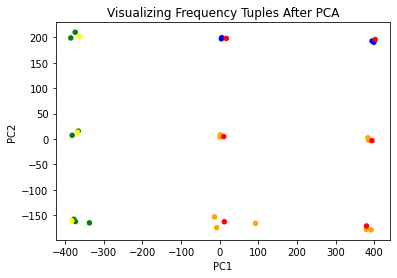

In [ ]:
plot_pca(df_weight_1)

In [ ]:
print_clusters(df_weight_1, kmeans_model_weight_1, num_clusters)

cluster 0
average point in cluster
GPUPower_Transformed    0.918750
MemPower_Transformed    0.873333
CPUPower_Transformed    0.944000
GPU_Transformed         0.514184
CPU_Transformed         0.928720
Mem_Transformed         0.823449
dtype: float64
    MemFreq  CPUBig  CPUSmall  GPUFreq
21      543     2.0       1.4      177
22      933     2.0       1.4      177
24      543     2.0       1.4      350
25      933     2.0       1.4      350
27      543     2.0       1.4      543
28      933     2.0       1.4      543
cluster 1
average point in cluster
GPUPower_Transformed    0.294444
MemPower_Transformed    0.300000
CPUPower_Transformed    0.204444
GPU_Transformed         0.305746
CPU_Transformed         0.523655
Mem_Transformed         0.758545
dtype: float64
    MemFreq  CPUBig  CPUSmall  GPUFreq
2       543     1.4       1.0      177
3       633     1.4       1.0      177
4       933     1.4       1.0      177
6       543     1.4       1.0      350
7       933     1.4       1.0      3

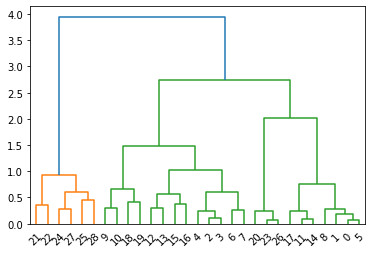

In [ ]:
# https://www.w3schools.com/python/python_ml_hierarchial_clustering.asp
# Not too sure how to determine number of clusters, if we can weight features (maybe?)
df_weight_1 = normalize_and_weight_performance(df, 1)

linkage_data = linkage(df_weight_1[["GPUPower_Transformed",
                                    "MemPower_Transformed",
                                    "CPUPower_Transformed",
                                    "GPU_Transformed",
                                    "CPU_Transformed",
                                    "Mem_Transformed"]],
                                    method = 'ward',
                                    metric = 'euclidean')
dendrogram(linkage_data)

plt.show()

In [ ]:
#Trying out your clustering based on EDP
NUM_CLUSTER = 4
col_max = {} #stores the max value of the column
NU = 2 # importance of power

In [ ]:
def get_data():
    df = pd.read_csv(DATA_PATH)
    # normalized the data to range 0-1
    for feat_name in df.columns:
        col_max[feat_name] = df[feat_name].max()
        df[feat_name] = df[feat_name].transform(lambda x: x/x.max()) # Different normalization!?
    
    return df

In [ ]:
def clustering_data(df):
    # we need to find a way to get clustering based on 
    df['EDPCPU'] = df['CPUPower']*pow(df["CPU"],NU)
    df['EDPMem'] = df['MemPower']*pow(df["Mem"],NU)
    df['EDPGPU'] = df['GPUPower']*pow(df["GPU"],NU)

    kmeanModel = KMeans(n_clusters=NUM_CLUSTER).fit(df[['EDPCPU','EDPMem','EDPGPU']])
    df['cluster'] = kmeanModel.labels_.tolist()
    return kmeanModel, df #added kmeanModel

In [ ]:
def print_cluster(df):
    cluster = [ [] for i in range(NUM_CLUSTER)]
    for idx, row in df.iterrows():
        cluster[int(row['cluster'])].append((row['CPUBig']*col_max['CPUBig'], row['CPUSmall']*col_max['CPUSmall'], row['MemFreq']*col_max['MemFreq'], row['GPUFreq']*col_max['GPUFreq']))
    
    for cl_idx in range(NUM_CLUSTER):
        for val in cluster[cl_idx]:
            print(cl_idx, val[0], val[1], val[2], val[3])

In [ ]:
df = get_data()
kmeanModel, df = clustering_data(df)


In [ ]:
print_cluster(df)

0 1.4 1.0 543.0 177.0
0 1.4 1.0 633.0 177.0
0 1.4 1.0 933.0 177.0
0 1.4 1.0 543.0 350.0
0 1.4 1.0 933.0 350.0
0 1.7 1.2 543.0 177.0
0 1.7 1.2 933.0 177.0
0 1.7 1.2 543.0 350.0
0 1.7 1.2 933.0 350.0
1 2.0 1.4 543.0 177.0
1 2.0 1.4 933.0 177.0
1 2.0 1.4 543.0 350.0
1 2.0 1.4 933.0 350.0
1 2.0 1.4 543.0 543.0
1 2.0 1.4 933.0 543.0
2 1.4 1.0 165.0 177.0
2 1.4 1.0 206.0 177.0
2 1.4 1.0 165.0 350.0
2 1.4 1.0 165.0 543.0
2 1.7 1.2 165.0 177.0
2 1.7 1.2 165.0 350.0
2 1.7 1.2 165.0 543.0
2 2.0 1.4 165.0 177.0
2 2.0 1.4 165.0 350.0
2 2.0 1.4 165.0 543.0
3 1.4 1.0 543.0 543.0
3 1.4 1.0 933.0 543.0
3 1.7 1.2 543.0 543.0
3 1.7 1.2 933.0 543.0


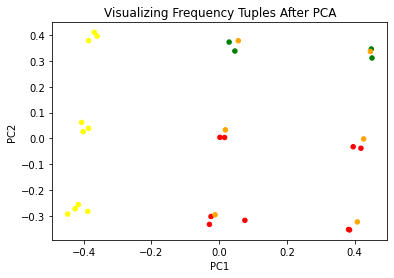

In [ ]:
plot_pca(df)

For new, larger set of data

In [ ]:
DATA_PATH = "./2_trials_sssp_results.csv"

In [ ]:
df = pd.read_csv(DATA_PATH, index_col = [0]) # 0th row -> allocation time really high, higher than 1st row with same frequencies?
df.head()

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time
0,200000.0,600000000.0,165000000.0,14426.656,212.701,4041.464,12715.806,2349.642,152.392,60558.0,26989.0,10421.0
1,200000.0,600000000.0,165000000.0,14090.860,35.091,4025.397,12979.838,2371.612,153.822,59814.0,26600.0,10401.0
2,200000.0,600000000.0,206000000.0,13906.032,31.617,3894.473,9412.836,2359.577,145.369,52305.0,26268.0,9529.0
3,200000.0,600000000.0,206000000.0,14069.236,29.732,3909.478,9586.179,2302.087,144.729,52877.0,26118.0,9819.0
4,200000.0,600000000.0,275000000.0,13651.293,29.488,3746.502,7371.586,2252.178,138.749,47113.0,25575.0,9177.0


In [ ]:
df.describe()

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time
count,1.456000e+03,1.456000e+03,1.456000e+03,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,8.000000e+05,4.051429e+08,4.735000e+08,5179.415452,14.466375,1587.262416,5610.596739,1054.904087,63.707203,24426.288462,9885.173077,3940.910714
std,3.742943e+05,1.400730e+08,2.314839e+08,3356.287470,8.607447,876.374788,3248.612947,559.384256,32.321782,11710.441884,5812.910883,2090.365188
min,2.000000e+05,1.770000e+08,1.650000e+08,2074.409000,5.402000,722.349000,2084.719000,377.904000,25.954000,9647.000000,3998.000000,1562.000000
25%,5.000000e+05,2.660000e+08,2.577500e+08,2862.673500,8.866000,980.237500,3096.772750,607.585750,39.233750,14807.750000,5834.000000,2447.500000
50%,8.000000e+05,4.200000e+08,4.780000e+08,3872.671500,12.592500,1286.233500,4388.766500,921.183500,55.832000,20848.000000,7746.000000,3318.500000
75%,1.100000e+06,5.430000e+08,6.567500e+08,6099.402250,18.158000,1904.674250,7611.282250,1326.872000,77.163500,32204.500000,11936.250000,4681.250000
max,1.400000e+06,6.000000e+08,8.250000e+08,15823.599000,212.701000,4613.548000,15005.290000,2827.852000,188.666000,67218.000000,27814.000000,11193.000000


In [ ]:
for i in range(0, df.shape[0], 2):
    if (df.iloc[i]["CPU Frequencies"] != df.iloc[i + 1]["CPU Frequencies"]) or \
       (df.iloc[i]["GPU Frequencies"] != df.iloc[i + 1]["GPU Frequencies"]) or \
       (df.iloc[i]["Mem Frequencies"] != df.iloc[i + 1]["Mem Frequencies"]):
        print("NOT EQUAL TO NEXT AT ROWS", i, "AND", i + 1)
# Each pair of rows has the same frequency

In [ ]:
# Group adjacent all rows with same combination of frequencies, get average times for each
averaged_df = df.groupby(["CPU Frequencies", "GPU Frequencies", "Mem Frequencies"]).mean().reset_index()
averaged_df.loc[averaged_df["CPU Frequencies"] == 200000.0][averaged_df["GPU Frequencies"] == 600000000.0][averaged_df["Mem Frequencies"] == 165000000.0]

<ipython-input-76-ae05ad984a3b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  averaged_df.loc[averaged_df["CPU Frequencies"] == 200000.0][averaged_df["GPU Frequencies"] == 600000000.0][averaged_df["Mem Frequencies"] == 165000000.0]


,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time
48,200000.0,600000000.0,165000000.0,14258.758,123.896,4033.4305,12847.822,2360.627,153.107,60186.0,26794.5,10411.0


In [ ]:
def normalize_features(df):
    '''Normalizes all the features other than the frequencies in the
       data frame "df" to between 0 and 1
       '''
    output = df.copy()

    for col in df.columns:
        if col not in ['CPU Frequencies', 'GPU Frequencies', 'Mem Frequencies']:
            output[col] = output[col].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

    return output

In [ ]:
# Normalize times, so that each feature ranges from 0 to 1
averaged_and_normalized_df = normalize_features(averaged_df)

In [ ]:
averaged_and_normalized_df

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time
0,200000.0,177000000.0,165000000.0,0.970179,0.255823,0.962849,0.978492,0.958793,0.968162,0.968615,0.994313,0.960169
1,200000.0,177000000.0,206000000.0,0.976235,0.260647,0.976525,0.674721,0.970930,0.873995,0.855984,0.960463,0.942736
2,200000.0,177000000.0,275000000.0,0.961417,0.235176,0.891660,0.471224,0.885683,0.790436,0.739120,0.938473,0.846276
3,200000.0,177000000.0,413000000.0,0.895731,0.206695,0.847789,0.358625,0.835973,0.734060,0.654515,0.898389,0.790703
4,200000.0,177000000.0,543000000.0,0.922751,0.194431,0.874403,0.362259,0.860385,0.740536,0.669656,0.885919,0.809826
...,...,...,...,...,...,...,...,...,...,...,...,...
723,1400000.0,600000000.0,413000000.0,0.017358,0.020195,0.040942,0.143189,0.054677,0.059124,0.077859,0.031511,0.053619
724,1400000.0,600000000.0,543000000.0,0.009160,0.011574,0.020905,0.067956,0.021009,0.033997,0.038819,0.017546,0.029371
725,1400000.0,600000000.0,633000000.0,0.005696,0.002014,0.012895,0.032049,0.013088,0.015179,0.018149,0.009542,0.019704
726,1400000.0,600000000.0,728000000.0,0.002649,0.009467,0.005234,0.018455,0.003604,0.008458,0.008237,0.004297,0.012467


In [ ]:
averaged_and_normalized_df.describe()

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time
count,7.280000e+02,7.280000e+02,7.280000e+02,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000
mean,8.000000e+05,4.051429e+08,4.735000e+08,0.227514,0.073808,0.229577,0.282039,0.281808,0.241796,0.258539,0.246453,0.244523
std,3.744230e+05,1.401212e+08,2.315635e+08,0.246083,0.067031,0.233194,0.262982,0.234164,0.207693,0.206490,0.244945,0.220803
min,2.000000e+05,1.770000e+08,1.650000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000e+05,2.660000e+08,2.577500e+08,0.057297,0.025915,0.068586,0.077824,0.094227,0.084038,0.088018,0.075587,0.086516
50%,8.000000e+05,4.200000e+08,4.780000e+08,0.133271,0.057455,0.149111,0.182291,0.226164,0.191261,0.196412,0.155377,0.177628
75%,1.100000e+06,5.430000e+08,6.567500e+08,0.298225,0.105178,0.313670,0.447962,0.395018,0.330172,0.401164,0.329094,0.322755
max,1.400000e+06,6.000000e+08,8.250000e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


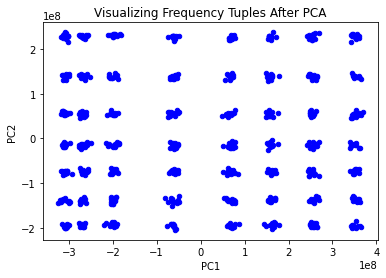

In [ ]:
def plot_pca_three_frequencies(df):
    ''' This function takes the data (in a format similar to that in 2_trials_sssp_results.csv)
        does PCA with 2 components on the 3 frequency values, and plots the frequency
        tuples in a 2-dimensional space.
        If the argument "df" has a column for clusters (there can be at most 7 clusters)
        then points representing each frequency tuple will be colored according to which
        cluster they were assigned to (based on their component power consumptions
        and performance benchmark scores)
        The purpose of this is to visualize our clustering.
        This is similar to plot_pca(), but is to be used on data from the Chai benchmark
        suite instead of AnTuTu, where we have only 3 frequencies instead of 4
    '''

    scaled_freq_df = StandardScaler().fit_transform(df[["CPU Frequencies", "GPU Frequencies", "Mem Frequencies"]])
    pca = PCA(n_components = 2)
    pca.fit(df[["CPU Frequencies", "GPU Frequencies", "Mem Frequencies"]])
    pca_df = pd.DataFrame(data = pca.transform(df[["CPU Frequencies", "GPU Frequencies", "Mem Frequencies"]]), columns = ["PC1", "PC2"])

    fig, ax = plt.subplots()

    # jitter() adds some jitter so we can see different points that are close
    # together distinctly.
    if "cluster" in df.columns:
        pca_df["cluster"] = df["cluster"]
        jitter(ax, pca_df["PC1"], pca_df["PC2"], c = pca_df["cluster"].map(color_dict)) 
    else:
        jitter(ax, pca_df["PC1"], pca_df["PC2"]) 

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title("Visualizing Frequency Tuples After PCA")

    plt.show()

plot_pca_three_frequencies(averaged_and_normalized_df)

In [ ]:
output = averaged_and_normalized_df.copy()
kmeanModel = KMeans(n_clusters = 4).fit(output[["Copy To Device Time",
                                                "Kernel Time",
                                                "Copy Back and Merge Time"]])

output["cluster"] = kmeanModel.labels_.tolist()

In [ ]:
for cluster in output["cluster"].unique():
    print(output.loc[output["cluster"] == cluster][["CPU Frequencies", "GPU Frequencies", "Mem Frequencies"]].to_string())

     CPU Frequencies  GPU Frequencies  Mem Frequencies
0           200000.0      177000000.0      165000000.0
1           200000.0      177000000.0      206000000.0
2           200000.0      177000000.0      275000000.0
3           200000.0      177000000.0      413000000.0
4           200000.0      177000000.0      543000000.0
5           200000.0      177000000.0      633000000.0
6           200000.0      177000000.0      728000000.0
7           200000.0      177000000.0      825000000.0
8           200000.0      266000000.0      165000000.0
9           200000.0      266000000.0      206000000.0
10          200000.0      266000000.0      275000000.0
11          200000.0      266000000.0      413000000.0
12          200000.0      266000000.0      543000000.0
13          200000.0      266000000.0      633000000.0
14          200000.0      266000000.0      728000000.0
15          200000.0      266000000.0      825000000.0
16          200000.0      350000000.0      165000000.0
17        

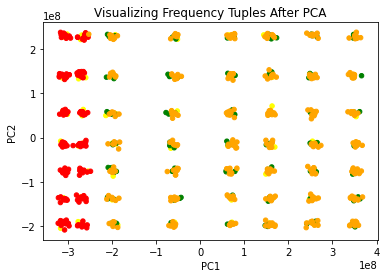

In [ ]:
plot_pca_three_frequencies(output)

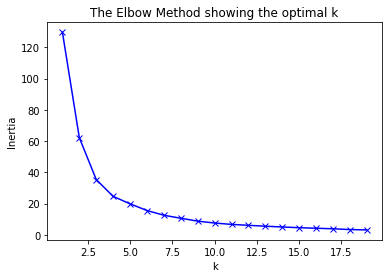

In [ ]:
K = range(1, 20)
inertias = []

for k in K:
    output = averaged_and_normalized_df.copy()
    kmeanModel = KMeans(n_clusters = k).fit(output[["Copy To Device Time",
                                                    "Kernel Time",
                                                    "Copy Back and Merge Time"]])
    output["cluster"] = kmeanModel.labels_.tolist()
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 4 seems best, again

In [ ]:
# Make new column that is (Copy To Device Time + Copy Back and Merge Time) / (Copy To Device Time + Kernel Time + Copy Back and Merge Time)
# Cluster based on it
df_transfer_percent = df.copy()
df_transfer_percent["Transfer Percentage"] = (df_transfer_percent["Copy To Device Time"]\
                                              + df_transfer_percent["Copy Back and Merge Time"]) /\
                                             (df_transfer_percent["Copy To Device Time"]\
                                              + df_transfer_percent["Kernel Time"]\
                                              + df_transfer_percent["Copy Back and Merge Time"])
df_transfer_percent.describe()

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time,Transfer Percentage
count,1.456000e+03,1.456000e+03,1.456000e+03,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,8.000000e+05,4.051429e+08,4.735000e+08,5179.415452,14.466375,1587.262416,5610.596739,1054.904087,63.707203,24426.288462,9885.173077,3940.910714,0.334320
std,3.742943e+05,1.400730e+08,2.314839e+08,3356.287470,8.607447,876.374788,3248.612947,559.384256,32.321782,11710.441884,5812.910883,2090.365188,0.106395
min,2.000000e+05,1.770000e+08,1.650000e+08,2074.409000,5.402000,722.349000,2084.719000,377.904000,25.954000,9647.000000,3998.000000,1562.000000,0.148663
25%,5.000000e+05,2.660000e+08,2.577500e+08,2862.673500,8.866000,980.237500,3096.772750,607.585750,39.233750,14807.750000,5834.000000,2447.500000,0.247941
50%,8.000000e+05,4.200000e+08,4.780000e+08,3872.671500,12.592500,1286.233500,4388.766500,921.183500,55.832000,20848.000000,7746.000000,3318.500000,0.327100
75%,1.100000e+06,5.430000e+08,6.567500e+08,6099.402250,18.158000,1904.674250,7611.282250,1326.872000,77.163500,32204.500000,11936.250000,4681.250000,0.399749
max,1.400000e+06,6.000000e+08,8.250000e+08,15823.599000,212.701000,4613.548000,15005.290000,2827.852000,188.666000,67218.000000,27814.000000,11193.000000,0.597609


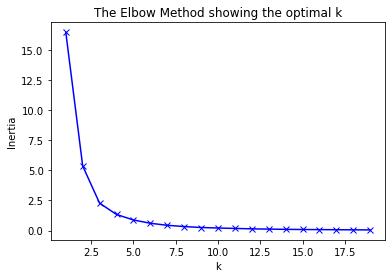

In [ ]:
# Find best K when using Transfer Percentage

K = range(1, 20)
inertias = []

for k in K:
    output = df_transfer_percent.copy()
    kmeanModel = KMeans(n_clusters = k).fit(output[["Transfer Percentage"]])
    output["cluster"] = kmeanModel.labels_.tolist()
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 3-4 seems best

In [ ]:
df_transfer_percent = df_transfer_percent.copy()
kmeanModel = KMeans(n_clusters = 3).fit(df_transfer_percent[["Transfer Percentage"]])
df_transfer_percent["cluster"] = kmeanModel.labels_.tolist()

In [ ]:
for cluster in df_transfer_percent["cluster"].unique():
    print(df_transfer_percent.loc[df_transfer_percent["cluster"] == cluster][["CPU Frequencies", "GPU Frequencies", "Mem Frequencies"]].to_string())

      CPU Frequencies  GPU Frequencies  Mem Frequencies
0            200000.0      600000000.0      165000000.0
1            200000.0      600000000.0      165000000.0
2            200000.0      600000000.0      206000000.0
3            200000.0      600000000.0      206000000.0
16           200000.0      543000000.0      165000000.0
17           200000.0      543000000.0      165000000.0
18           200000.0      543000000.0      206000000.0
19           200000.0      543000000.0      206000000.0
32           200000.0      480000000.0      165000000.0
33           200000.0      480000000.0      165000000.0
34           200000.0      480000000.0      206000000.0
35           200000.0      480000000.0      206000000.0
48           200000.0      420000000.0      165000000.0
49           200000.0      420000000.0      165000000.0
50           200000.0      420000000.0      206000000.0
51           200000.0      420000000.0      206000000.0
64           200000.0      350000000.0      1650

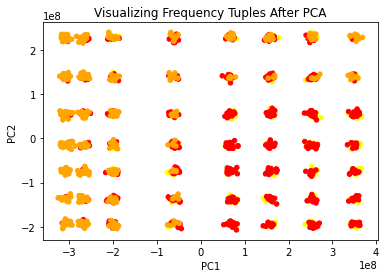

In [ ]:
plot_pca_three_frequencies(df_transfer_percent)

In [ ]:
averaged_and_normalized_df.columns

Index(['CPU Frequencies', 'GPU Frequencies', 'Mem Frequencies',
       'Initialization Time', 'Allocation Time', 'Copy To Device Time',
       'Kernel Time', 'Copy Back and Merge Time', 'Deallocation Time',
       'Real Time', 'User Time', 'System Time'],
      dtype='object')

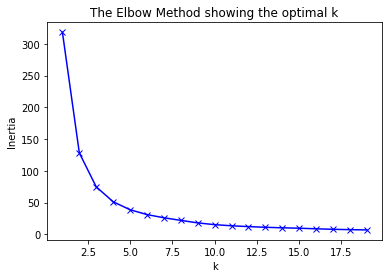

In [ ]:
# Find best K when using all features

K = range(1, 20)
inertias = []

for k in K:
    output = averaged_and_normalized_df.copy()
    kmeanModel = KMeans(n_clusters = k).fit(output[['Initialization Time',
                                                    'Allocation Time',
                                                    'Copy To Device Time',
                                                    'Kernel Time',
                                                    'Copy Back and Merge Time',
                                                    'Deallocation Time',
                                                    'Real Time',
                                                    'User Time',
                                                    'System Time']])
    output["cluster"] = kmeanModel.labels_.tolist()
    inertias.append(kmeanModel.inertia_)

plt.plot(K, inertias, "bx-")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("The Elbow Method showing the optimal k")
plt.show()

# 4 seems best

In [ ]:
output = averaged_and_normalized_df.copy()
kmeanModel = KMeans(n_clusters = 4).fit(output[['Initialization Time',
                                                'Allocation Time',
                                                'Copy To Device Time',
                                                'Kernel Time',
                                                'Copy Back and Merge Time',
                                                'Deallocation Time',
                                                'Real Time',
                                                'User Time',
                                                'System Time']])
output["cluster"] = kmeanModel.labels_.tolist()

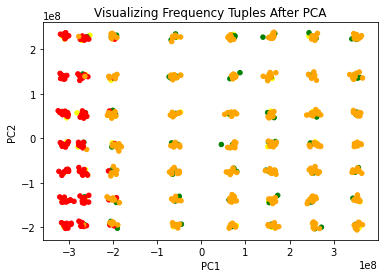

In [ ]:
plot_pca_three_frequencies(output)

In [ ]:
output

,CPU Frequencies,GPU Frequencies,Mem Frequencies,Initialization Time,Allocation Time,Copy To Device Time,Kernel Time,Copy Back and Merge Time,Deallocation Time,Real Time,User Time,System Time,cluster
0,200000.0,177000000.0,165000000.0,0.970179,0.255823,0.962849,0.978492,0.958793,0.968162,0.968615,0.994313,0.960169,2
1,200000.0,177000000.0,206000000.0,0.976235,0.260647,0.976525,0.674721,0.970930,0.873995,0.855984,0.960463,0.942736,2
2,200000.0,177000000.0,275000000.0,0.961417,0.235176,0.891660,0.471224,0.885683,0.790436,0.739120,0.938473,0.846276,2
3,200000.0,177000000.0,413000000.0,0.895731,0.206695,0.847789,0.358625,0.835973,0.734060,0.654515,0.898389,0.790703,2
4,200000.0,177000000.0,543000000.0,0.922751,0.194431,0.874403,0.362259,0.860385,0.740536,0.669656,0.885919,0.809826,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1400000.0,600000000.0,413000000.0,0.017358,0.020195,0.040942,0.143189,0.054677,0.059124,0.077859,0.031511,0.053619,1
724,1400000.0,600000000.0,543000000.0,0.009160,0.011574,0.020905,0.067956,0.021009,0.033997,0.038819,0.017546,0.029371,1
725,1400000.0,600000000.0,633000000.0,0.005696,0.002014,0.012895,0.032049,0.013088,0.015179,0.018149,0.009542,0.019704,1
726,1400000.0,600000000.0,728000000.0,0.002649,0.009467,0.005234,0.018455,0.003604,0.008458,0.008237,0.004297,0.012467,1


In [ ]:
# No hyperparameter optimization, using defaults only
clf = RandomForestClassifier()
X = output[['Initialization Time', 'Allocation Time', 'Copy To Device Time',
            'Kernel Time', 'Copy Back and Merge Time', 'Deallocation Time',
            'Real Time', 'User Time', 'System Time']]
y = output[["cluster"]]
clf.fit(X, y)
print(clf.predict([[0.970179, 0.255823, 0.962849, 0.978492, 0.958793, 0.968162,
                    0.968615, 0.994313, 0.960169]])) # This was originally from cluster 3

<ipython-input-80-aefb3fd1eb6b>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X, y)


[2]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
clf.score(X, y) # Training error. 100% accuracy here (maybe overfit?)

1.0

In [ ]:
clf.feature_importances_  # Higher = more important
# 'Initialization Time', 'Allocation Time', 'Copy To Device Time', 'Kernel Time', 'Copy Back and Merge Time',
# 'Deallocation Time', 'Real Time', 'User Time', 'System Time'

NameError: ignored

In [ ]:
# Print frequencies in each cluster